### Импорт библиотек

In [167]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import warnings
warnings.simplefilter('ignore')

In [168]:
from sklearn.metrics import classification_report

from sklearn.metrics import precision_recall_curve

In [169]:
from sklearn.model_selection import GridSearchCV

### Загрузка датасета и препроцессинг

In [170]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
sample = pd.read_csv('./data/sample_submission.csv')

In [171]:
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


#### Описания полей
    client_id - идентификатор клиента
    education - уровень образования
    sex - пол заемщика
    age - возраст заемщика
    car - флаг наличия автомобиля
    car_type - флаг автомобиля иномарки
    decline_app_cnt - количество отказанных прошлых заявок
    good_work - флаг наличия “хорошей” работы
    bki_request_cnt - количество запросов в БКИ
    home_address - категоризатор домашнего адреса
    work_address - категоризатор рабочего адреса
    income - доход заемщика
    foreign_passport - наличие загранпаспорта
    sna - связь заемщика с клиентами банка
    first_time - давность наличия информации о заемщике
    score_bki - скоринговый балл по данным из БКИ
    region_rating - рейтинг региона
    app_date - дата подачи заявки
    default - флаг дефолта по кредиту (целевая)

Зададим client_id как индекс, а app_date - как дату

In [172]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [173]:
train = train.set_index('client_id')

train['app_date'] = train['app_date'].astype('datetime64').dt.date
train['app_year'] = train['app_date'].apply(lambda x: x.year).astype('int64')
train['app_month'] = train['app_date'].apply(lambda x: x.month).astype('int64')
train['app_day'] = train['app_date'].apply(lambda x: x.day).astype('int64')
train = train.drop(columns=['app_date'])

In [174]:
### есть пропуски в параметре 'education'
train.isnull().sum()

education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
app_year              0
app_month             0
app_day               0
dtype: int64

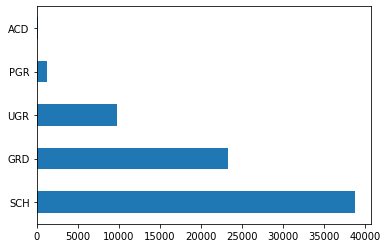

In [175]:
train['education'].value_counts().plot.barh()
plt.show()

In [176]:
### заполним пропуски значением 'not specified'
train['education'] = train.education.fillna('not specified')

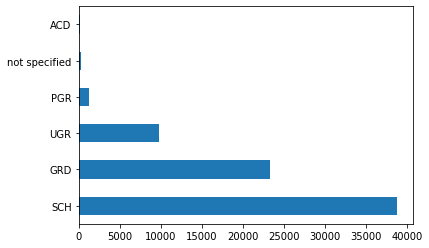

In [177]:
train['education'].value_counts().plot.barh()
plt.show()

In [178]:
train = train.drop_duplicates() ### уберём дубликаты строк

In [179]:
train.head()

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,app_year,app_month,app_day
client_id,,,,,,,,,,,,,,,,,,,,
25905,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,2014,2,1
63161,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,2014,3,12
25887,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,2014,2,1
16222,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,2014,1,23
101655,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,2014,4,18


### EDA

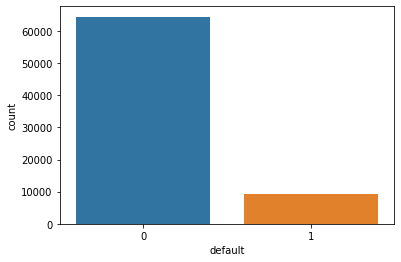

In [180]:
### баланс классов целевой переменной смещён к значению 0 - то есть, без дефолта
sns.countplot(train['default'])
plt.show()

In [181]:
# train = pd.concat([train[train['default']==1], train[train['default']==0].iloc[:(len(train[train['default']==0]))*3, :]])

In [182]:
### создадим веса для регуляризации
class_weights = {}
for value in train['default'].unique():
    class_weights[value] = np.log(len(train) / len(train[train['default']==value]))

In [183]:
bin_cols = [] ### список бинарных параметров
cat_cols = [] ### список категориальных параметров
num_cols = [] ### список численных параметров

In [184]:
columns = train.columns ### все параметры в датасете
digit_cols = train.describe().columns ### все параметры, значения которых - числовые
for column in columns:
    if column != 'default' and 'id' not in column:
        if train[column].nunique() == 2:
            bin_cols.append(column)
        if (column in digit_cols) and (column not in bin_cols) and ('app' in column or train[column].nunique()>10):
            num_cols.append(column)
        if (column not in bin_cols) and (column not in num_cols):
            cat_cols.append(column)

In [185]:
bin_cols

['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [186]:
cat_cols

['education',
 'region_rating',
 'home_address',
 'work_address',
 'sna',
 'first_time']

In [187]:
num_cols

['age',
 'decline_app_cnt',
 'score_bki',
 'bki_request_cnt',
 'income',
 'app_year',
 'app_month',
 'app_day']

#### Числовые переменные

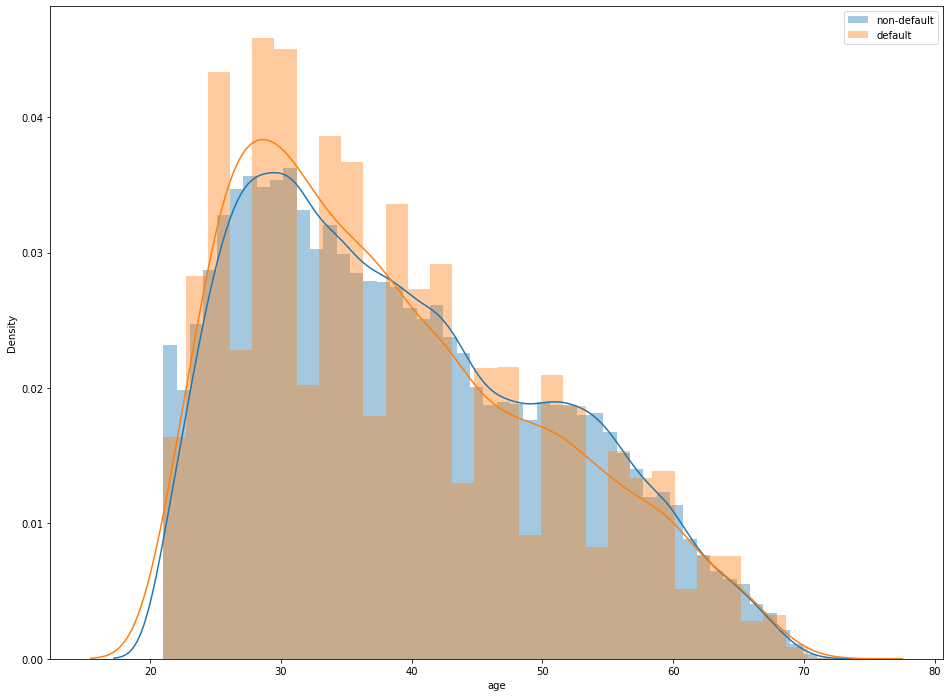

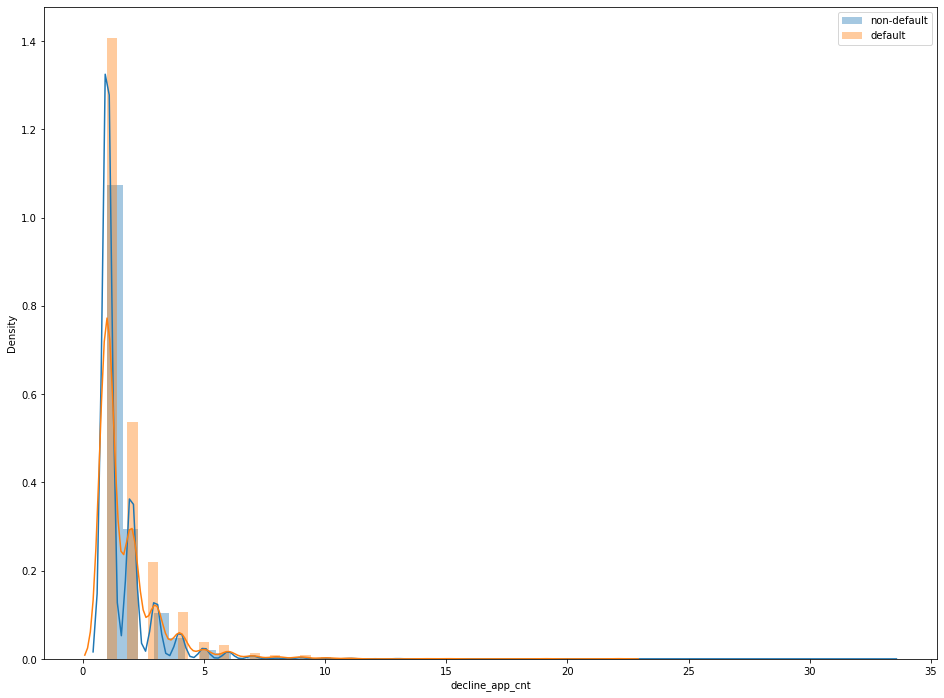

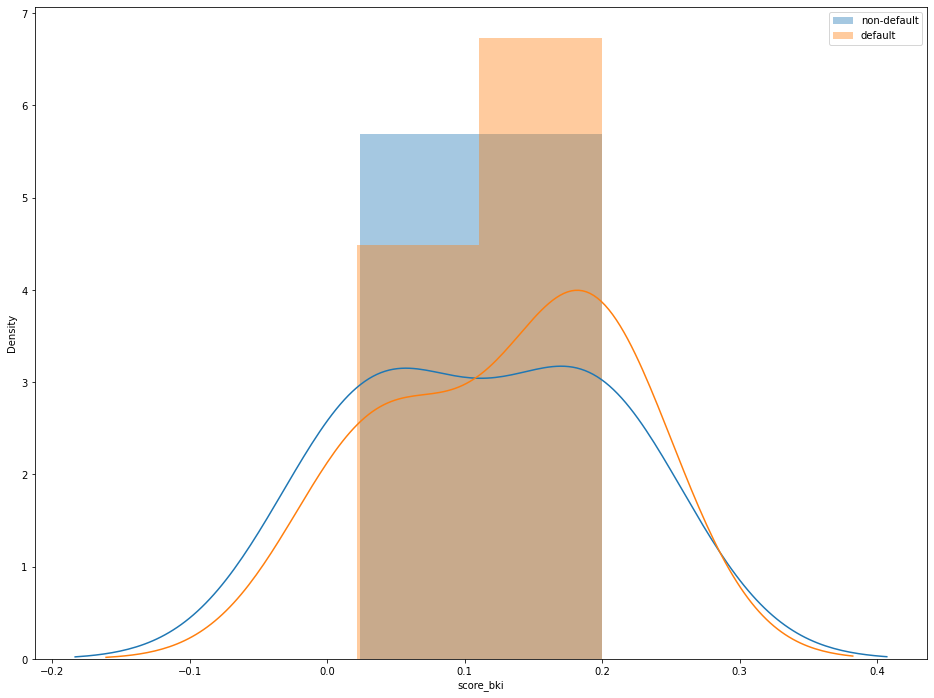

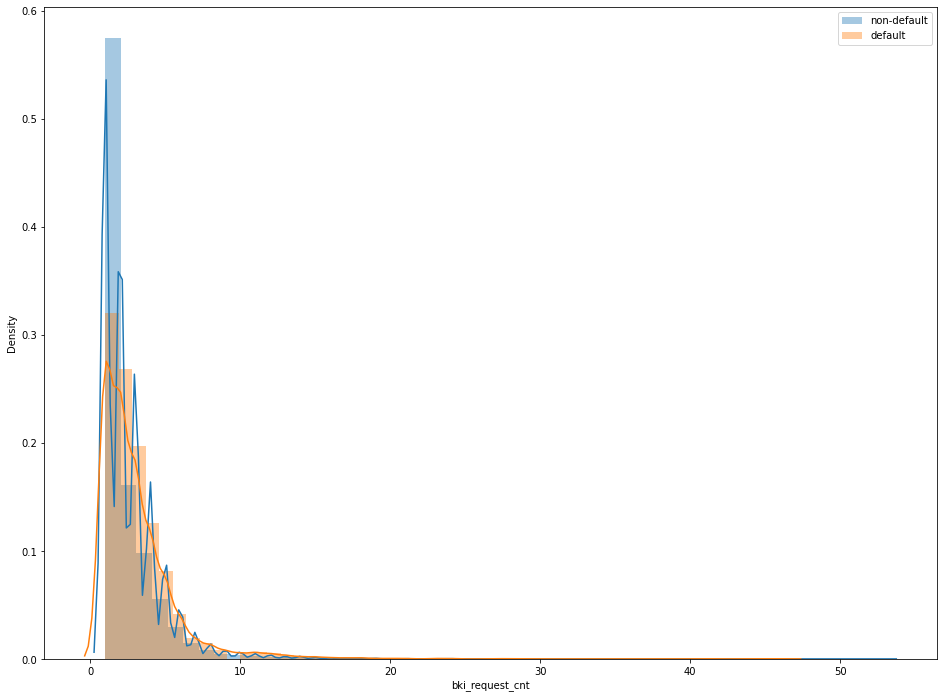

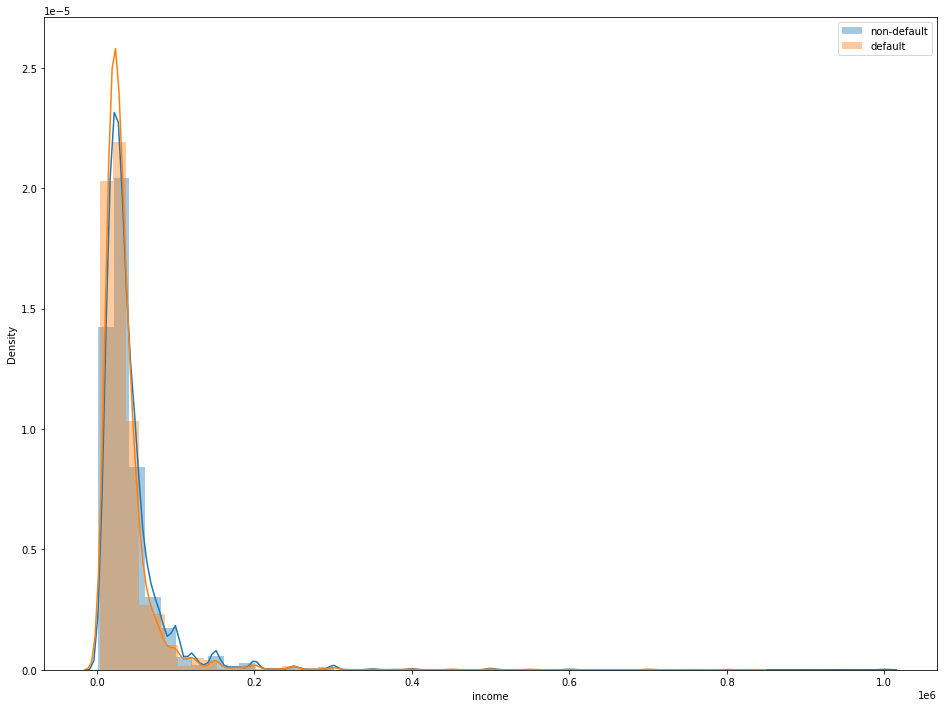

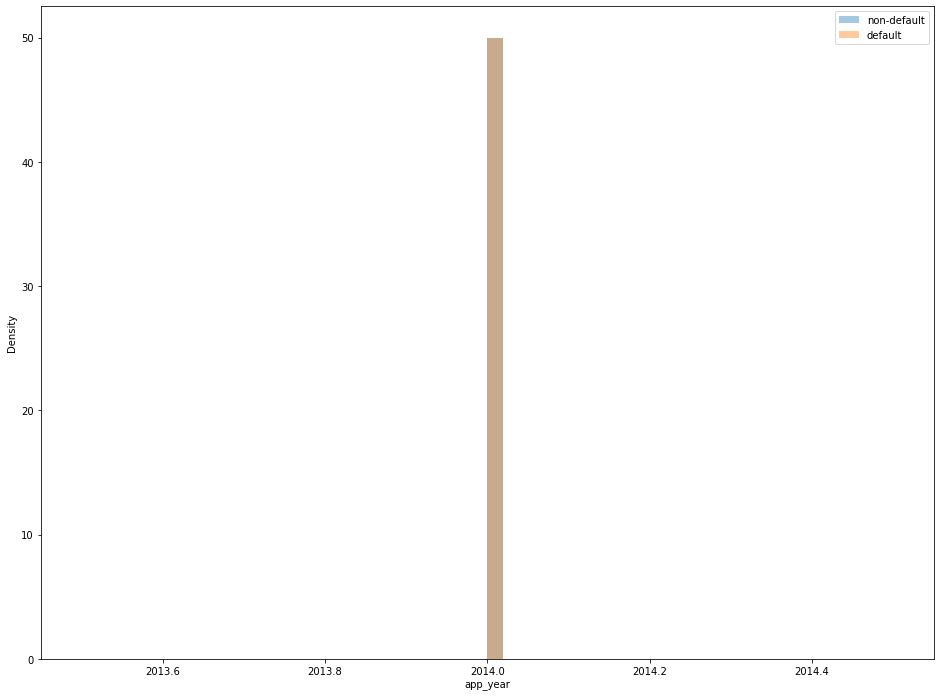

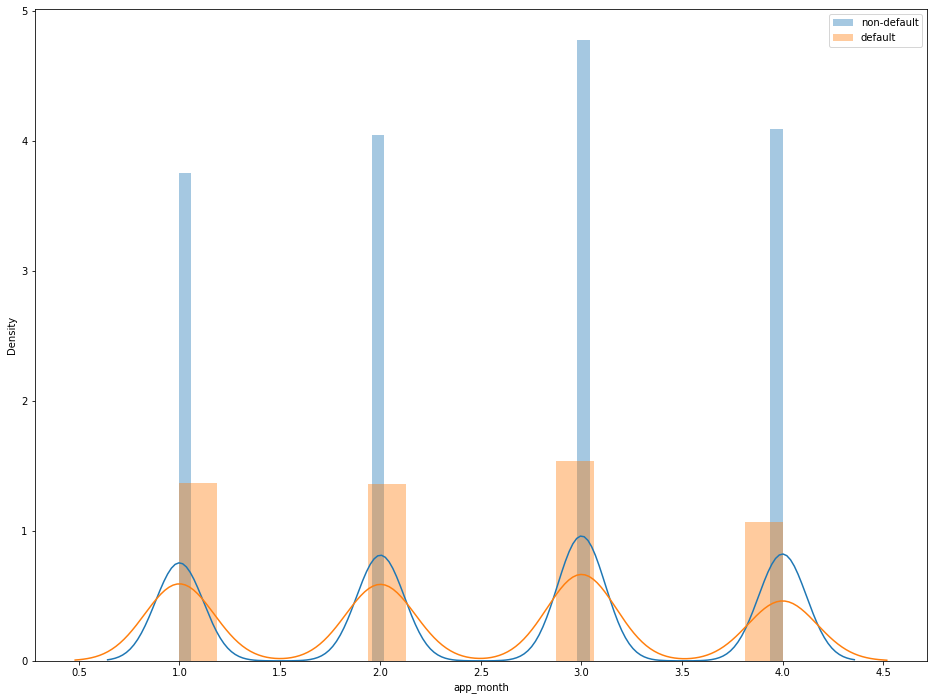

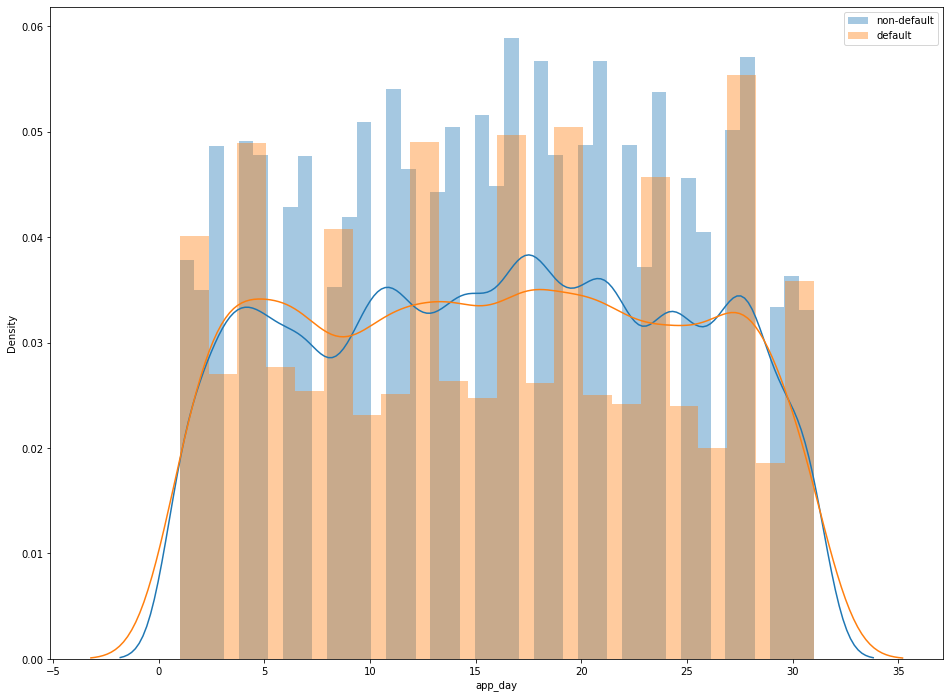

In [188]:
for i in num_cols:
    fig, ax = plt.subplots(figsize=(16,12))
    sns.distplot(train[(train[i]>0)&(train['default']==0)][i], label='non-default')
    sns.distplot(train[(train[i]>0)&(train['default']==1)][i], label='default')
    plt.legend()
    plt.show()
    
### часть данных смещена - логарифмируем

In [189]:
train = train.drop(columns=['app_year']) ### в колонке year только одно значение

num_cols.remove('app_year')

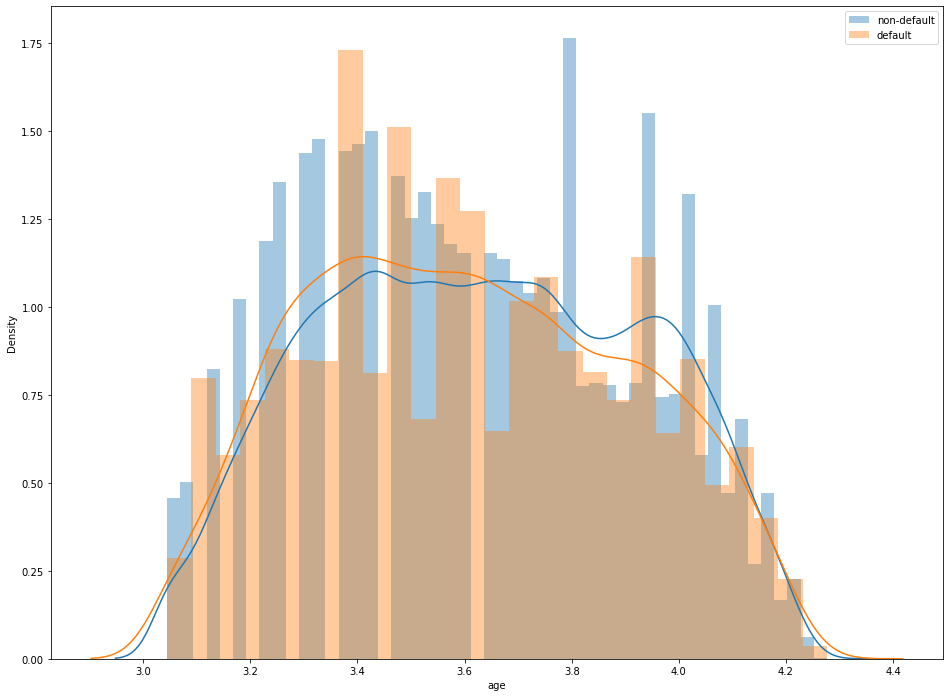

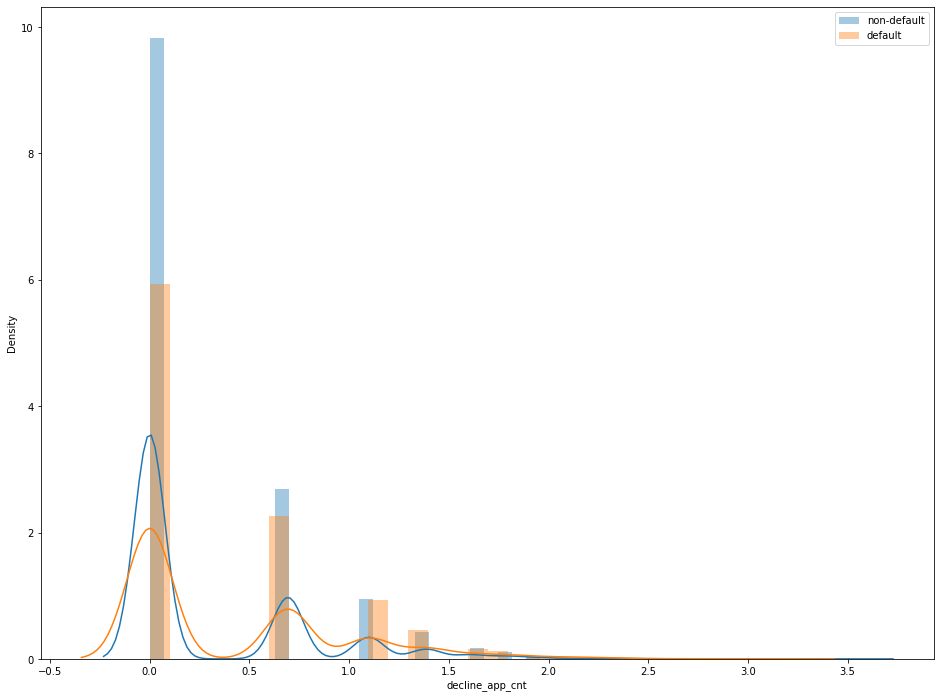

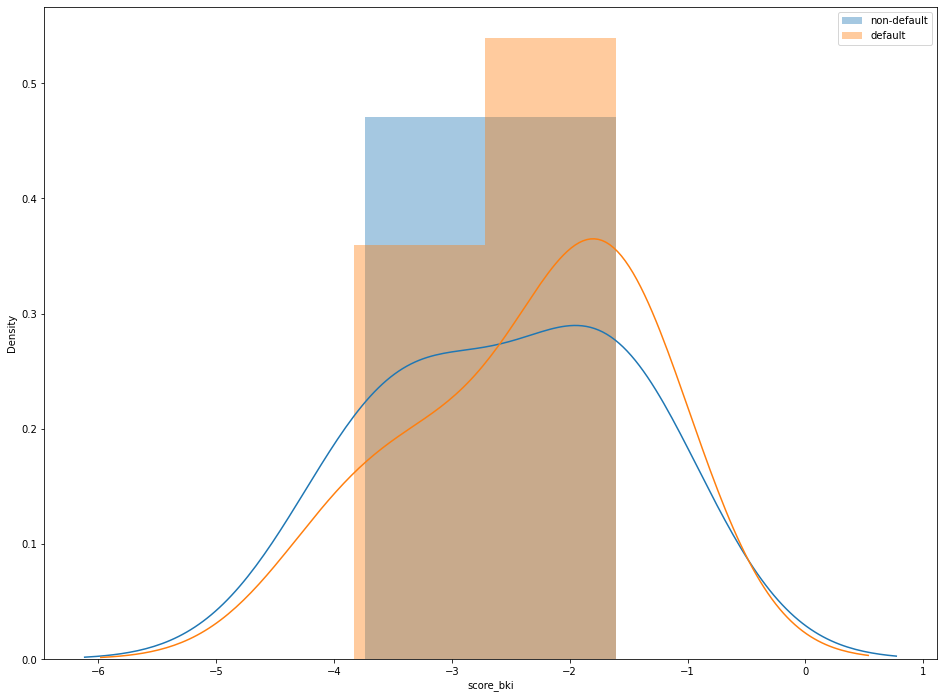

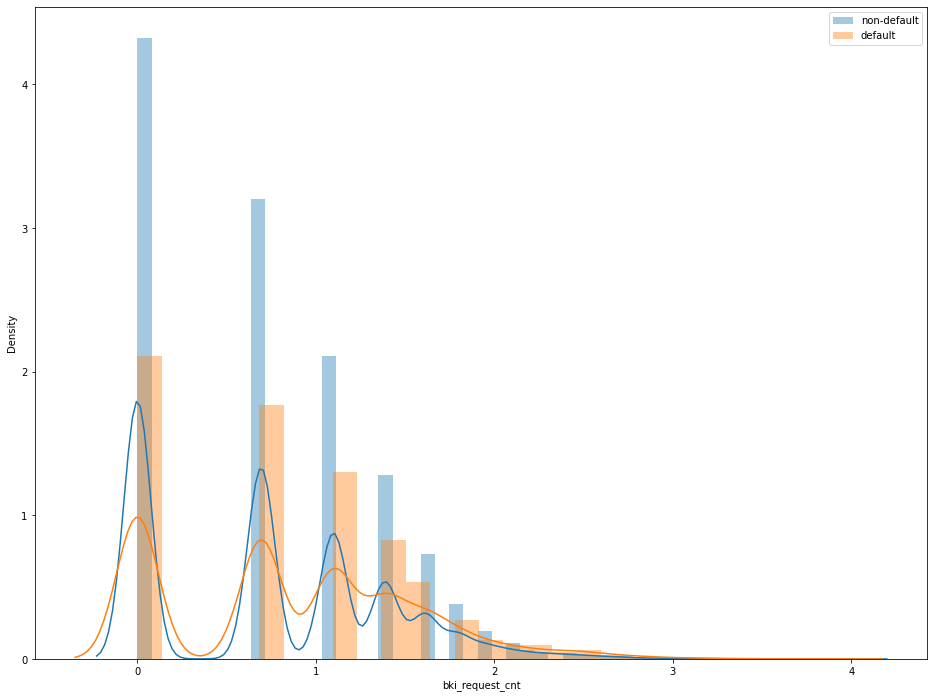

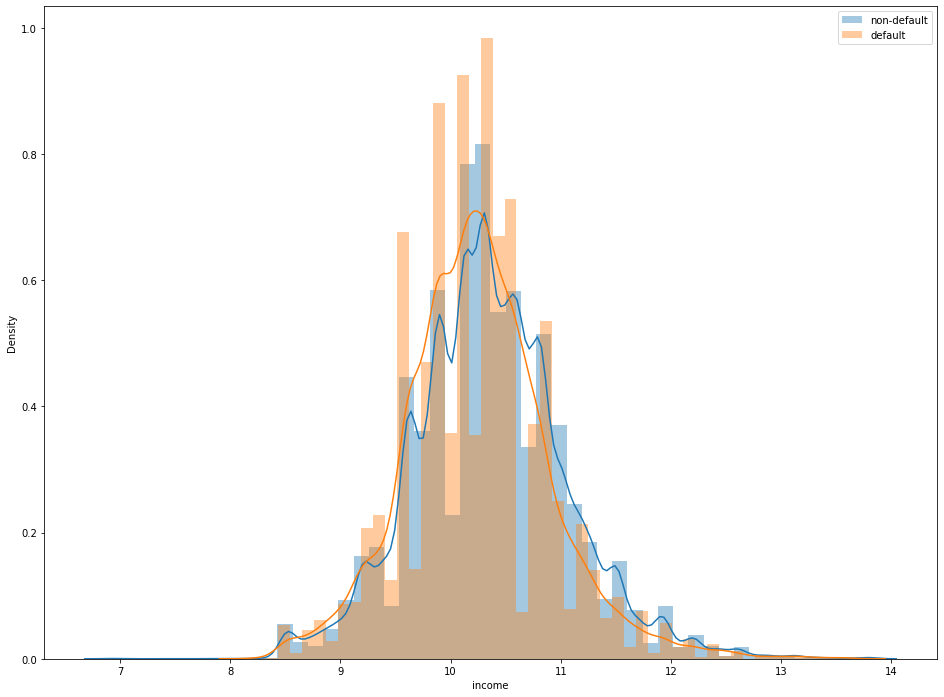

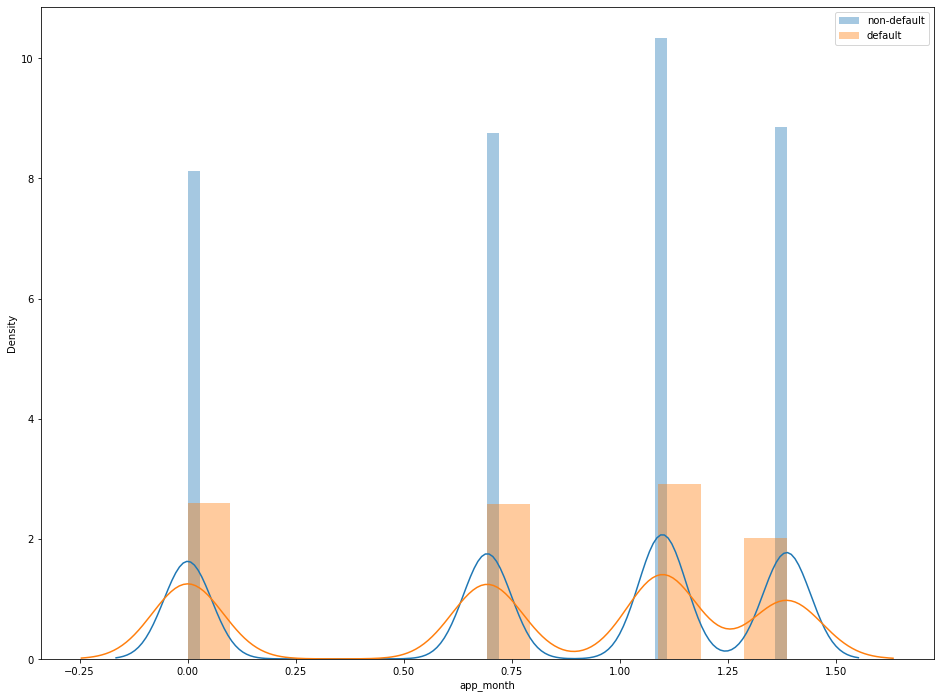

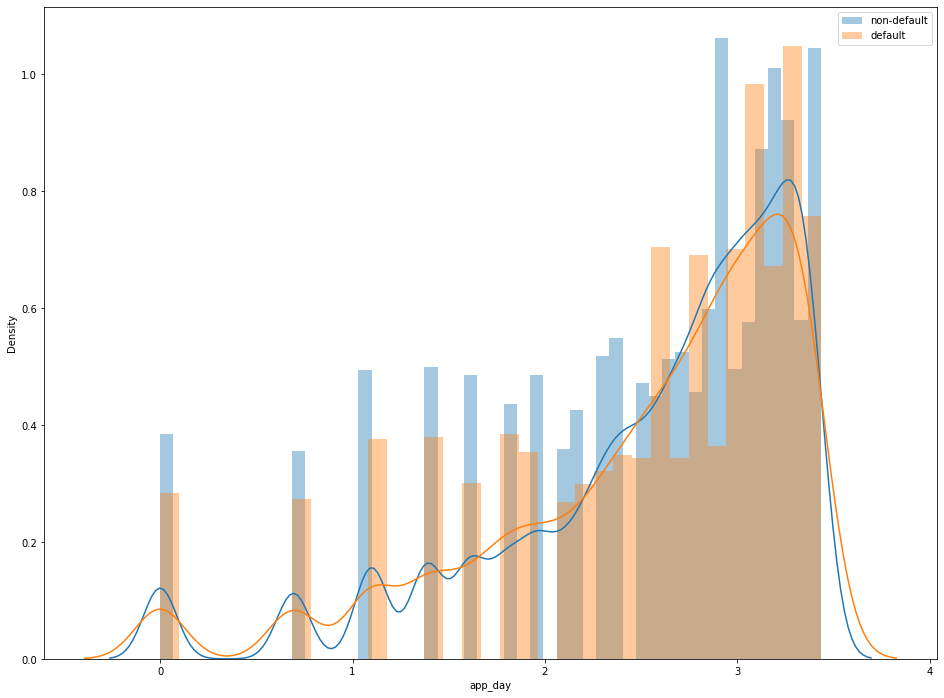

In [190]:
for i in num_cols:
    fig, ax = plt.subplots(figsize=(16,12))
    sns.distplot(np.log(train[(train[i]>0)&(train['default']==0)][i]), label='non-default')
    sns.distplot(np.log(train[(train[i]>0)&(train['default']==1)][i]), label='default')
    plt.legend()
    plt.show()

In [191]:
###for i in ['age', 'income']:
###    train[i] = np.log(train[i])

In [192]:
### убираем выбросы
for column in train.columns:
    tw_f = np.percentile(train[i], 25)
    s_f = np.percentile(train[i], 75)
    IQR = s_f - tw_f
    train = train[(train[i]>=tw_f-1.5*IQR)&(train[i]<=s_f+1.5*IQR)]

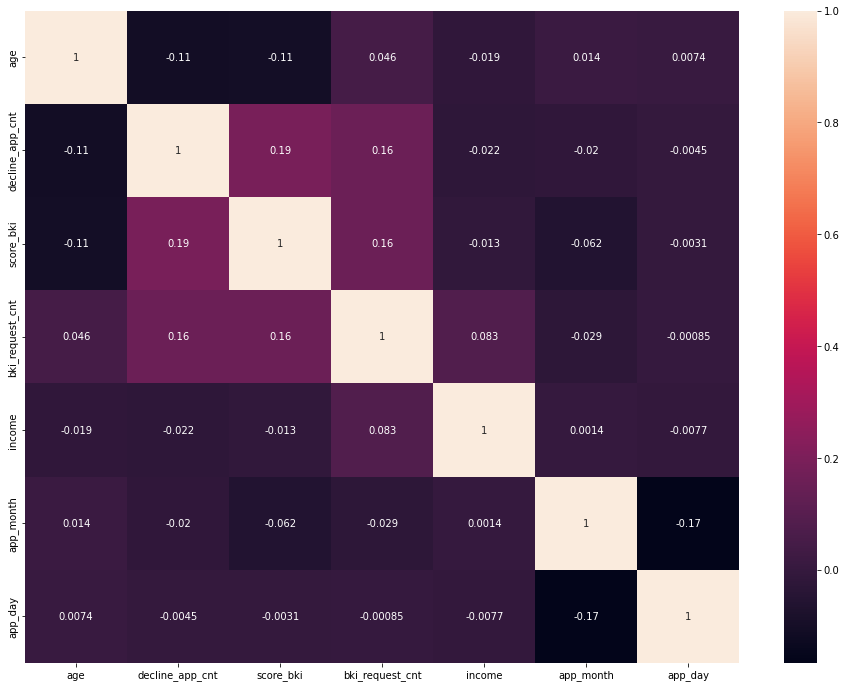

In [193]:
### Слабая корреляция между рассмотренными признаками
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(train[num_cols].corr(), annot=True)
plt.show()

#### Категориальные переменные

In [194]:
### перекодируем все бинарные переменные 
label_encoder = LabelEncoder()

for i in bin_cols:
    train[i] = label_encoder.fit_transform(train[i])

In [195]:
train.sample(10)

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,app_month,app_day
client_id,,,,,,,,,,,,,,,,,,,
107412,UGR,0,42,1,1,0,0,-1.148019,1,40,2,3,350000,1,3,0,1,4,27
34043,SCH,1,39,1,0,0,1,-1.890333,0,50,1,1,40000,1,4,1,1,2,10
14265,GRD,0,40,0,0,2,0,-1.700252,9,50,1,2,25000,4,1,0,0,1,21
92805,UGR,1,47,0,0,0,0,-1.319643,2,50,2,3,20000,4,1,0,0,4,9
57817,UGR,1,35,1,1,0,0,-2.739516,5,80,2,3,90000,1,3,0,0,3,6
35454,SCH,1,28,1,1,0,0,-2.236161,2,80,2,3,45000,3,3,0,0,2,11
85563,UGR,0,47,0,0,0,0,-2.336534,1,50,2,3,9000,1,1,0,0,4,2
52078,UGR,1,29,1,0,0,1,-2.445197,1,80,1,3,60000,2,1,0,0,2,28
83708,UGR,0,39,0,0,0,0,-2.576996,0,50,1,1,25000,1,4,0,0,3,31


In [196]:
train = pd.get_dummies(train)###.drop(columns=['education_not specified'])

In [197]:
cat_cols.remove('education')
for i in train.columns:
    if 'education_' in i:
        bin_cols.append(i)

In [198]:
train.head()

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,...,foreign_passport,default,app_month,app_day,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,education_not specified
client_id,,,,,,,,,,,,,,,,,,,,,
25905,1,62,1,1,0,0,-2.008753,1,50,1,...,0,0,2,1,0,0,0,1,0,0
63161,0,59,0,0,0,0,-1.532276,3,50,2,...,0,0,3,12,0,0,0,1,0,0
25887,1,25,1,0,2,0,-1.408142,1,80,1,...,1,0,2,1,0,0,0,1,0,0
16222,0,53,0,0,0,0,-2.057471,2,50,2,...,0,0,1,23,0,0,0,1,0,0
101655,1,48,0,0,0,1,-1.244723,1,60,2,...,1,0,4,18,0,1,0,0,0,0


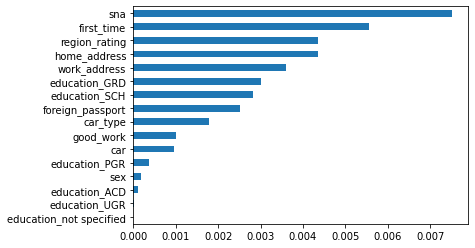

In [199]:
### самый важный категориальный признак - sna
imp_cat = Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
plt.show()

In [200]:
###train = train.drop(columns=cats_to_avoid)

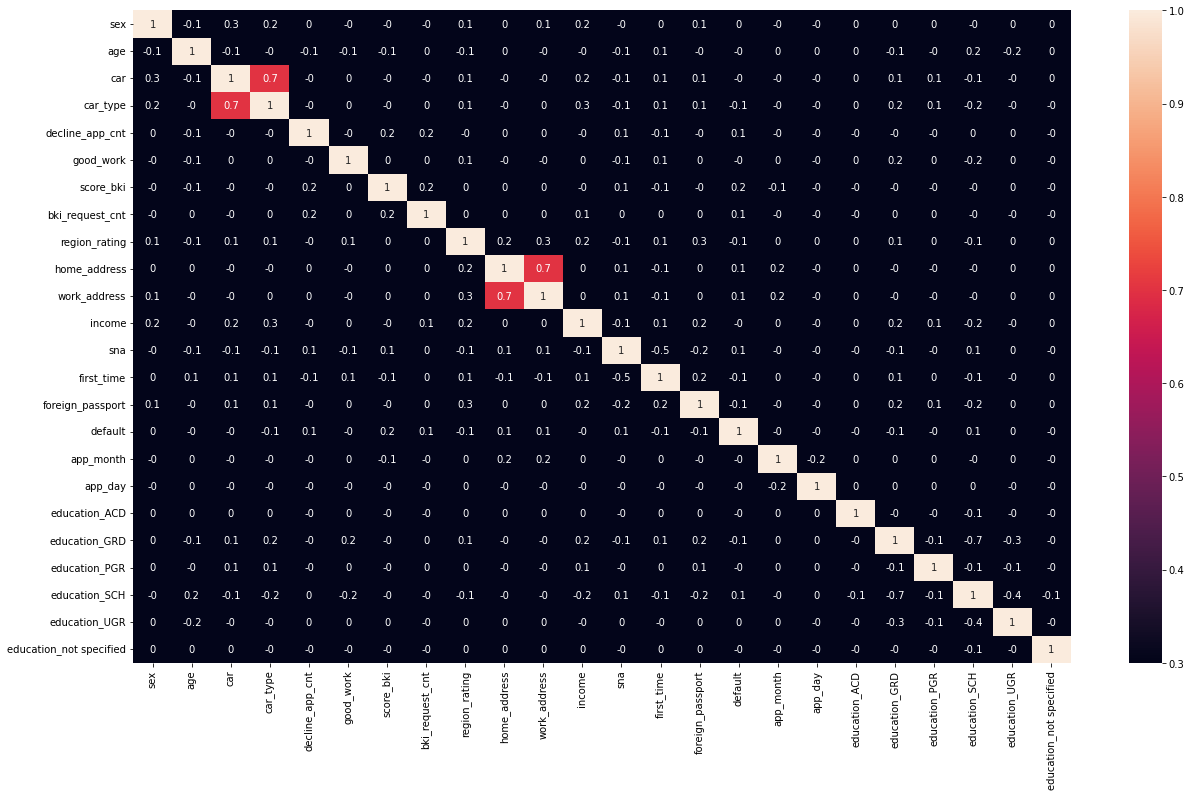

In [201]:
### есть признаки с высокой корреляцией
fig,ax = plt.subplots(figsize=(21,12))
sns.heatmap(np.round(train.corr(),1), vmin=0.3, annot=True)
plt.show()

In [202]:
# ### work_address / home_address - между ними большая корреляция
# train['work_home_address'] = np.sqrt(train['work_address'] * train['home_address'])
# train = train.drop(columns=['work_address', 'home_address'])

In [203]:
# ### car / car_type - между ними большая корреляция
# train['car_and_type'] = np.sqrt(train['car'] * train['car_type'])
# train = train.drop(columns=['car', 'car_type'])

In [204]:
# fig,ax = plt.subplots(figsize=(21,12))
# sns.heatmap(np.round(train.corr(),1), vmax=-0.3, annot=True)
# plt.show()

In [205]:
# train['first_time_sna'] = np.sqrt(train['first_time'] * train['sna'])
# ###train['education_GRD_SCH_UGR'] = (train['education_GRD'] + train['education_SCH'] + train['education_UGR'])/3
# train = train.drop(columns=['first_time', 'sna'])

In [206]:
# fig,ax = plt.subplots(figsize=(21,12))
# sns.heatmap(train.corr(), vmax=-0.3)
# plt.show()

### Модель

In [207]:
X = train.loc[:, train.columns!='default']
y = train.loc[:, 'default']

In [208]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [210]:
logreg = LogisticRegression(random_state=42, class_weight=class_weights)
logreg.fit(X_train, y_train)
probs = logreg.predict_proba(X_test)
probs = probs[:,1]

### Метрики

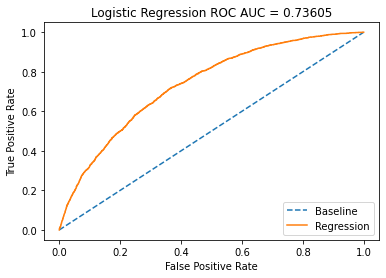

In [211]:
false_positives, true_positives, threshold = roc_curve(y_test, probs)

roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(false_positives, true_positives, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [212]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 7)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(random_state=42, class_weight=class_weights)
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 4.641588833612778


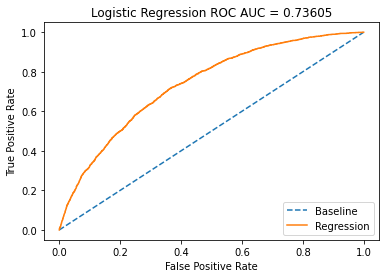

In [213]:
logreg = LogisticRegression(random_state=42, class_weight=class_weights, C=best_model.best_estimator_.get_params()['C'], penalty = best_model.best_estimator_.get_params()['penalty'])
y_pred = logreg.fit(X_train, y_train).predict_proba(X_test)
false_positives, true_positives, threshold = roc_curve(y_test, y_pred[:,1])
roc_auc = roc_auc_score(y_test, y_pred[:,-1])
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(false_positives, true_positives, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [214]:
print(classification_report(y_test, np.round(y_pred[:,1])))

              precision    recall  f1-score   support

           0       0.97      0.32      0.49     16138
           1       0.16      0.93      0.28      2312

    accuracy                           0.40     18450
   macro avg       0.57      0.63      0.38     18450
weighted avg       0.87      0.40      0.46     18450



In [215]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, 1])

Text(0.5, 1.0, 'precision-recall curve')

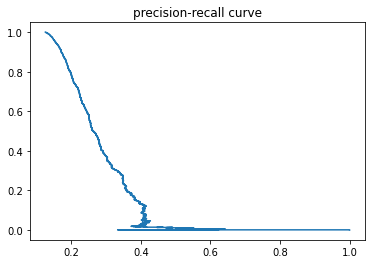

In [216]:
plt.plot(precision, recall)
plt.title('precision-recall curve')

### Работа с тестовой выборкой

In [217]:
test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [218]:
def preprocessing(train: pd.DataFrame):
    train['app_date'] = train['app_date'].astype('datetime64').dt.date
    train['app_month'] = train['app_date'].apply(lambda x: x.month).astype('int64')
    train['app_day'] = train['app_date'].apply(lambda x: x.day).astype('int64')
    train = train.drop(columns=['app_date'])
    bin_cols = [] ### список бинарных параметров
    cat_cols = [] ### список категориальных параметров
    num_cols = [] ### список численных параметров
    columns = train.columns ### все параметры в датасете
    digit_cols = train.describe().columns ### все параметры, значения которых - числовые
    for column in columns:
        if column != 'default' and 'id' not in column:
            if train[column].nunique() == 2:
                bin_cols.append(column)
            if (column in digit_cols) and (column not in bin_cols) and ('app' in column or train[column].nunique()>10):
                num_cols.append(column)
            if (column not in bin_cols) and (column not in num_cols):
                cat_cols.append(column)
    ### заполним пропуски значением 'not specified'
    train['education'] = train.education.fillna('not specified')
    ###for i in ['age', 'income']:
    ###    train[i] = np.log(train[i])
    label_encoder = LabelEncoder()
    for i in bin_cols:
        train[i] = label_encoder.fit_transform(train[i])
    train = pd.get_dummies(train)
#     train['work_home_address'] = np.sqrt(train['work_address'] * train['home_address'])
#     train = train.drop(columns=['work_address', 'home_address'])
#     train['car_and_type'] = np.sqrt(train['car'] * train['car_type'])
#     train['first_time_sna'] = np.sqrt(train['first_time'] * train['sna'])
#     train['education_GRD_SCH'] = (train['education_GRD'] + train['education_SCH']) / 2
#     train = train.drop(columns=['first_time', 'sna'])
#     train = train.drop(columns=['car', 'car_type'])
    ###train = train.drop(columns = cats_to_avoid)
    train.loc[:, train.columns!='client_id'] = scaler.transform(train.loc[:, train.columns!='client_id'])
    return train

In [219]:
test1 = preprocessing(test)

In [220]:
probs_test = logreg.predict_proba(test1.loc[:, test1.columns!='client_id'])[:, 1]
test1['default'] = probs_test

In [ ]:
result = test1[['client_id', 'default']].to_csv('output/kaggle_scoring.csv', index=False)